## Training on MNIST Dataset with Contrastive Pairs Loss
-------------------------

In [1]:
import os
#import torchsummary
import matplotlib.pyplot as plt
import torch
import numpy as np
import cv2
from torch import nn
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import transforms, models

os.chdir('..'); os.chdir('..')
print(os.getcwd()) # Should be .\ContrastiveLearning
from Code.trainers import Trainer
#from Code.models import SiameseNet
from Code.losses import form_triplets, ContrastiveLoss
from Code.dataloaders import LabeledContrastiveDataset
from Code.utils import extract_embeddings, plot_embeddings


# Hyperparameters
N = 3000
EMB_SIZE = 32
DEVICE = 'cuda'
LR = 0.0005
EPOCHS = 10
MARGIN = 1.0
NAME = 'MNIST_PAIR_LOSS_' + '_'.join([str(N), str(EMB_SIZE), str(LR), str(EPOCHS), str(MARGIN)])

# Reproduciblity
SEED = 911
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)

D:\Research\ContrastiveRepresentationLearning


## Create Dataloader and Inspect Data
---------------------

In [2]:
root = r'D:\Data\Imagery\MNIST\MNIST'
mean, std = 0.1307, 0.3081
tfms  =    transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((mean,), (std,))
                             ])


lcd = LabeledContrastiveDataset(root, transforms=tfms)


In [3]:
datadict = lcd.__getitem__(4)
print(datadict["x1"].shape); print(datadict["x2"].shape)

torch.Size([10, 1, 28, 28])
torch.Size([10, 1, 28, 28])


C:\Users\Shair\.conda\envs\pytorch\lib\site-packages\torchvision\transforms\functional.py:114: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:143.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


In [4]:
from torchvision import transforms


train_sampler = SubsetRandomSampler(range(int(N*0.9)))
test_sampler = SubsetRandomSampler(range(int(N*0.9), N))

siamese_train_loader = torch.utils.data.DataLoader(lcd, batch_size=None, sampler=train_sampler)
siamese_test_loader = torch.utils.data.DataLoader(lcd, batch_size=None, shuffle=test_sampler)


## Model
------------

In [5]:
embedding_net = models.resnet18()
embedding_net.conv1 = nn.Conv2d(1, 64, (7,7), (2,2), (3,3))
embedding_net.fc = nn.Linear(512, EMB_SIZE)
model = embedding_net
model.train(); print() ; #torchsummary.summary(model, input_size = [(1,28,28),(1, 28, 28)], device=DEVICE)

## Training
-------------------------

In [6]:

TL = ContrastiveLoss(margin=1.0, mode='pairs')

t = Trainer(model = model, 
            dataloader = siamese_train_loader,
            lr=LR,
            loss_function= TL)

In [7]:
losses = t.train(EPOCHS, print_every=1)#, writer = writer)

  0%|                                                                                         | 0/2700 [00:00<?, ?it/s]

----- Epoch: 0 -----


  0%|                                                                                 | 3/2700 [00:00<01:58, 22.82it/s]

Avg train loss: 0.04647024116440055
----- Epoch: 1 -----


  0%|                                                                                 | 3/2700 [00:00<01:48, 24.83it/s]

Avg train loss: 0.02958299503657515
----- Epoch: 2 -----


  0%|                                                                                 | 3/2700 [00:00<01:45, 25.64it/s]

Avg train loss: 0.02280590784906603
----- Epoch: 3 -----


  0%|                                                                                 | 3/2700 [00:00<01:44, 25.86it/s]

Avg train loss: 0.017991772402449355
----- Epoch: 4 -----


  0%|                                                                                 | 3/2700 [00:00<01:46, 25.41it/s]

Avg train loss: 0.015129790639827759
----- Epoch: 5 -----


  0%|                                                                                 | 3/2700 [00:00<01:46, 25.21it/s]

Avg train loss: 0.01323084365027221
----- Epoch: 6 -----


  0%|                                                                                 | 3/2700 [00:00<01:53, 23.80it/s]

Avg train loss: 0.011587587445622171
----- Epoch: 7 -----


  0%|                                                                                 | 3/2700 [00:00<01:45, 25.63it/s]

Avg train loss: 0.010335876384317311
----- Epoch: 8 -----


  0%|                                                                                 | 3/2700 [00:00<01:46, 25.42it/s]

Avg train loss: 0.009299262001579317
----- Epoch: 9 -----


100%|██████████████████████████████████████████████████████████████████████████████| 2700/2700 [01:48<00:00, 24.94it/s]

Avg train loss: 0.008486182559181838


Text(0.5, 0, 'Epochs')

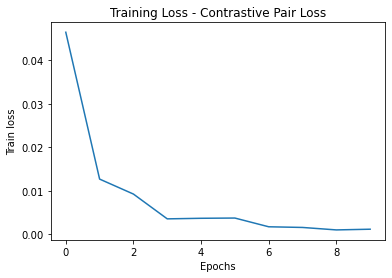

In [8]:
plt.plot(losses)
plt.title("Training Loss - Contrastive Pair Loss")
plt.ylabel("Train loss"); plt.xlabel("Epochs")


In [9]:
losses

[0.04647024116440055,
 0.01269574890874975,
 0.009251733474047796,
 0.00354936606259933,
 0.003681863589341379,
 0.0037361087024944733,
 0.0017280502177219306,
 0.0015738989551832843,
 0.001006346939675369,
 0.001168467577604512]

## Inspecting Embeddings
-------------------

In [10]:
EMBS_TO_VISUALIZE = N - int(N*0.9)

In [11]:
test_embs = extract_embeddings(siamese_test_loader, model, EMBS_TO_VISUALIZE, reduce_to_dimension=2)

performing PCA to reduce embeddings to 2 dimensions
0.45079494 % variance explained using PCA


In [12]:
test_embs.head()

,Emb,Label
0,"[-0.10142087, 0.9861553]",5
1,"[-0.29980388, 0.47371897]",6
2,"[0.32089403, -0.11234523]",2
3,"[-0.10230484, -0.2726765]",9
4,"[-0.33229306, -0.032638874]",8


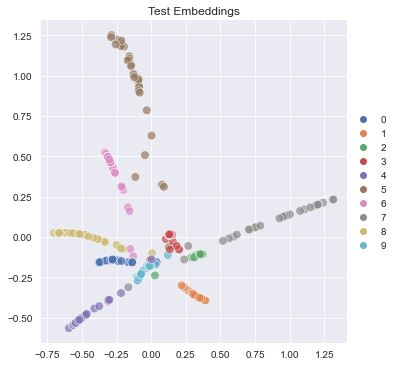

In [13]:

plot_embeddings(test_embs)

## Saving Model
-------------------------

In [32]:
weightfol = r'D:/Research/ContrastiveRepresentationLearning/Outputs/Weights'
outpath = weightfol + r"/" + NAME + '.pth'
torch.save(model.state_dict(), outpath); print("Model saved at: ", outpath)

Model saved at:  D:/Research/ContrastiveRepresentationLearning/Outputs/Weights/MNIST_PAIR_LOSS_3000_32_0.0005_10_1.0.pth
